In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow as tf
import tensorflow.feature_column as fc

In [5]:
#load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


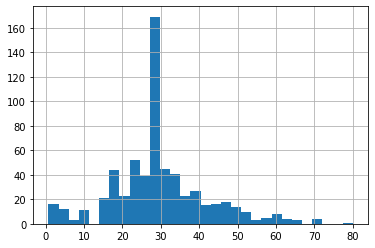

In [10]:
dftrain.age.hist(bins=30)

In [11]:
#feature_engineering_for_the_model
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [12]:
dict(dftrain)

{'sex': 0        male
 1      female
 2      female
 3      female
 4        male
         ...  
 622      male
 623      male
 624    female
 625    female
 626      male
 Name: sex, Length: 627, dtype: object,
 'age': 0      22.0
 1      38.0
 2      26.0
 3      35.0
 4      28.0
        ... 
 622    28.0
 623    25.0
 624    19.0
 625    28.0
 626    32.0
 Name: age, Length: 627, dtype: float64,
 'n_siblings_spouses': 0      1
 1      1
 2      0
 3      1
 4      0
       ..
 622    0
 623    0
 624    0
 625    1
 626    0
 Name: n_siblings_spouses, Length: 627, dtype: int64,
 'parch': 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 622    0
 623    0
 624    0
 625    2
 626    0
 Name: parch, Length: 627, dtype: int64,
 'fare': 0       7.2500
 1      71.2833
 2       7.9250
 3      53.1000
 4       8.4583
         ...   
 622    10.5000
 623     7.0500
 624    30.0000
 625    23.4500
 626     7.7500
 Name: fare, Length: 627, dtype: float64,
 'class': 0       Third
 

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle= False)

In [14]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.8344965, 'auc_precision_recall': 0.79105014, 'average_loss': 0.49440625, 'label/mean': 0.375, 'loss': 0.488629, 'precision': 0.63793105, 'prediction/mean': 0.44675884, 'recall': 0.74747473, 'global_step': 200}


In [15]:
#Derived Feature Columns
age_x_gender = tf.feature_column.crossed_column(['age','sex'], hash_bucket_size=100)
age_x_gender

CrossedColumn(keys=('age', 'sex'), hash_bucket_size=100, hash_key=None)

In [ ]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(result)

In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.83116007, 'auc_precision_recall': 0.75167704, 'average_loss': 0.52790326, 'label/mean': 0.375, 'loss': 0.5185147, 'precision': 0.7205882, 'prediction/mean': 0.26583835, 'recall': 0.4949495, 'global_step': 200}


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/np/jy3lt_3d5r9cn16svmf_bqz40000gp/T/tmp4p8ykfjo/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


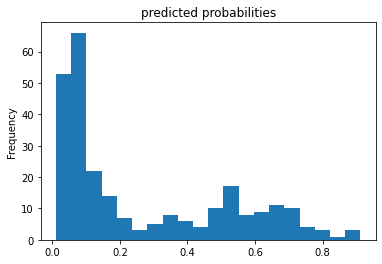

In [17]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

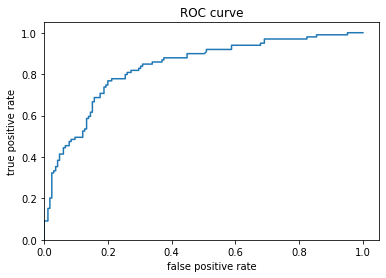

In [18]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)